In [4]:
import numpy as np
from astropy.io import ascii
from pylab import *
from astropy.table import Table, vstack
import pandas as pd
from expecto import get_spectrum
from scipy.interpolate import RegularGridInterpolator as rgi
from itertools import product
%run Interpolate.ipynb
%run GetSpectra.ipynb
%run Binning.ipynb

In [3]:
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

'''
reads in .dat files. col1 is wavelength, col2 is transmission. Files are labeled with water content level in mm 
water content levels are listed in the array above. resolution is 200,000.
'''

d = {}
i=0
for n in water_array:
    water_content = str(water_array[i])
    d["data"+water_content] = ascii.read("transmission{0}_hi_res.dat".format(water_content))
    d["data"+water_content+"_pd"] = d["data"+water_content].to_pandas()
    #print(d["data"+water_content+"_pd"])
    i+=1

In [4]:
'''
for loop creates transmission values in shape necessary for interpolation function
'''
water_array = [1.0, 1.5, 2.5, 3.5, 5.0]

flux_array = []
i=0
for n in water_array:
    water_array_i = str(water_array[i])
    d["flux"+water_array_i] = np.array(d["data"+water_array_i+"_pd"]["col2"])
    flux_array.append(d["flux"+water_array_i])
    i+=1

In [5]:
pwv = np.load("pwv_target.npy")

In [6]:
diff_spec2 = diff_spec(4000, 6000, pwv, pwv, 1.8, 1.95)

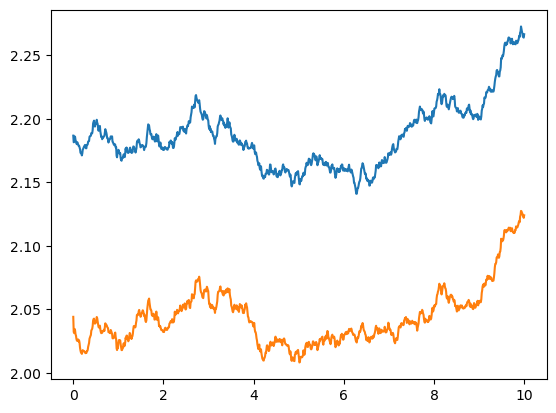

In [8]:
from pylab import *
from scipy.stats import binned_statistic

def P_pwv(v, c = 1e-7):

    return c * v**-2

def angular_correlation(separation):

    return np.exp(-0.5*(separation/45)**2)


def power_spectrum(N, omega_max, M, timestamps, mean = 0, target = True, phase = None, separation = None):

    delta_omega = omega_max / N
    A_n = np.array([2 * np.sqrt(P_pwv(n * delta_omega + .00001) * delta_omega) for n in range(N + 1)])
    A_n_zero = np.array([0 for n in range(N + 1, M)])
    A_n = np.concatenate((A_n, A_n_zero))

    
    if target:
        phi = np.random.uniform(0,2 * np.pi, M)
        B_n = np.exp(1.0j*phi)
        phase = B_n
        pwv = np.real(np.fft.fft(A_n*B_n)/2)
        
        pwv += mean
        pwv_delta_t = np.pi/omega_max
        pwv_t = np.arange(0, M*pwv_delta_t, pwv_delta_t)/3600
        binned_pwv, binned_pwv_t, _ = binned_statistic(pwv_t, pwv, bins = timestamps)
        binned_pwv = np.insert(binned_pwv, 0, np.mean(binned_pwv))

    else:
        B_n = phase
        phi = np.random.uniform(0, 2*np.pi, M)
        C_n = A_n*angular_correlation(separation)
        D_n = A_n*np.sqrt(1 - angular_correlation(separation)**2)
        E_n = np.exp(1.0j*phi)
        
        pwv = np.real(np.fft.fft(C_n*B_n + D_n*E_n)/2)
        
        pwv += mean
        
        pwv_delta_t = np.pi/omega_max
        pwv_t = np.arange(0, M*pwv_delta_t, pwv_delta_t)/3600
        binned_pwv, binned_pwv_t, _ = binned_statistic(pwv_t, pwv, bins = timestamps)
        binned_pwv = np.insert(binned_pwv, 0, np.mean(binned_pwv))


    return binned_pwv_t, binned_pwv, phase, mean

if __name__ == "__main__":

    timestamps = np.linspace(0,10,1000) #time in hours
    t, target_star_pwv, target_star_phase, target_star_mean = power_spectrum(12000, 1, 24000, timestamps, mean = 2)
    t1, comparison_star_pwv, _, _ = power_spectrum(12000, 1, 24000, timestamps, mean = target_star_mean, target = False, phase = target_star_phase, separation = 25)

    plt.plot(t, target_star_pwv)
    plt.plot(t, comparison_star_pwv)
    plt.show()


In [1]:
diff_spec3 = diff_spec_v2(4000, 6000, target_star_pwv, comparison_star_pwv, 1.8, 1.95)

NameError: name 'diff_spec_v2' is not defined

In [ ]:
plt.plot(diff_spec3[1])

In [ ]:
plt.plot(pwv)

In [ ]:
#print(target_star_pwv)
print(len(target_star_pwv))
print(len(comparison_star_pwv))

In [12]:
diff_spec4 = diff_spec_v2(4000, 6000, target_star_pwv, target_star_pwv, 1.8, 1.95)

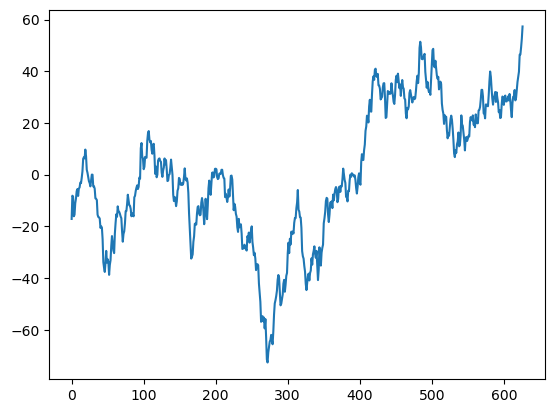

In [14]:
plt.plot(diff_spec4[0]*10**6)

In [15]:
diff_spec5 = diff_spec_v2(4000, 6000, target_star_pwv, comparison_star_pwv, 1.8, 1.95)

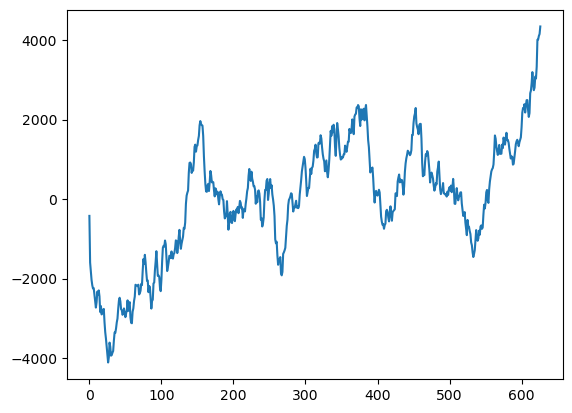

In [44]:
plt.plot(diff_spec5[0]*10**6)

In [23]:
cold_star = spectrum(4000)


In [27]:
pwv_test = binned_flux_pwv_v2(cold_star, target_star_pwv, 1.8, 1.95, 200)

In [37]:
#time_series = np.array(pwv_test, dtype = object)
#time_series = np.array(pwv_test[0][:,0])
time_series = stacking(pwv_test)

In [39]:
#time_series_new = time_series[:,0]
#time_series_new
time_series2 = time_series[0][:,0]

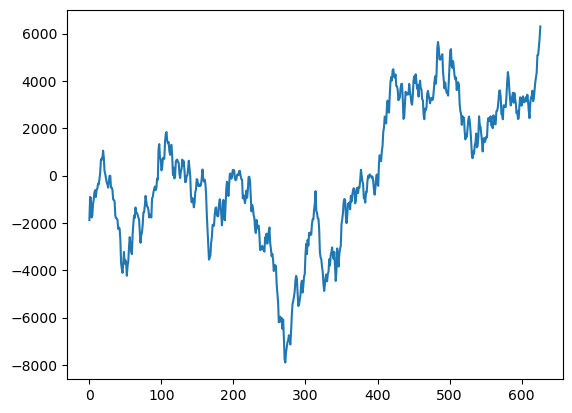

In [43]:
plt.plot(((time_series2-np.mean(time_series2))/np.mean(time_series2))*10**6)

In [45]:
hot_star = spectrum(6000)

In [47]:
pwv_test2 = binned_flux_pwv_v2(hot_star, comparison_star_pwv, 1.8, 1.95, 200)

In [48]:
time_series_comp = stacking(pwv_test2)

In [49]:
time_series2_comp = time_series_comp[0][:,0]

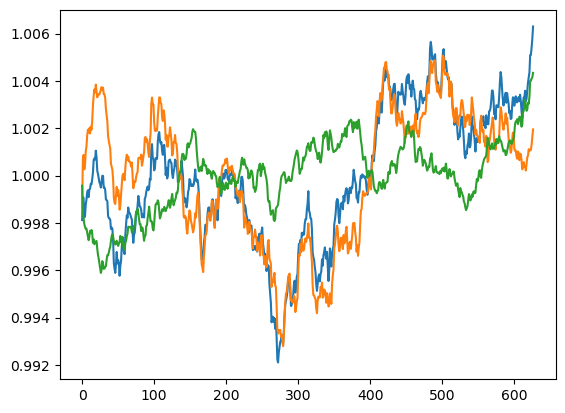

In [94]:
plt.plot(((time_series2)/np.mean(time_series2)))
plt.plot(((time_series2_comp)/np.mean(time_series2_comp)))
#plt.plot(((time_series2)/np.mean(time_series2))/((time_series2_comp)/np.mean(time_series2_comp)))
divided = time_series2/time_series2_comp
normalized = divided/np.mean(divided)
plt.plot(normalized)

[2.00263865e+15 2.00460818e+15 2.00452394e+15 2.00286372e+15
 2.00299881e+15 2.00396500e+15 2.00436886e+15 2.00499308e+15
 2.00517010e+15 2.00458890e+15]
0.00043439916968395154


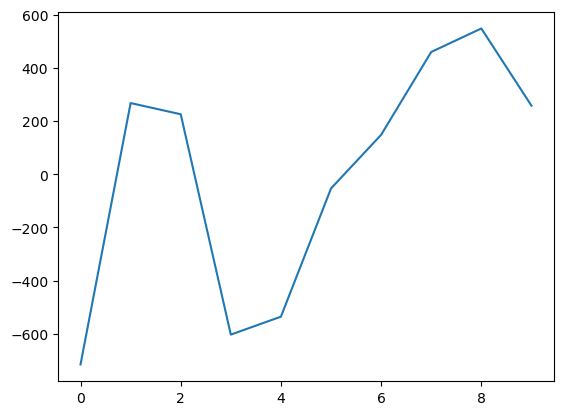

In [109]:
print(time_series2[0:10])
std_dev = np.std(time_series2[0:10]/np.mean(time_series2[0:10]))
print(std_dev)
plt.plot(((time_series2[0:10]/np.mean(time_series2[0:10]))-1)*10**6)

[3.88756292e+15 3.89596026e+15 3.89663281e+15 3.89427881e+15
 3.89506015e+15 3.89725647e+15 3.89801085e+15 3.89983716e+15
 3.90078436e+15 3.90034851e+15]
0.000940463872727838


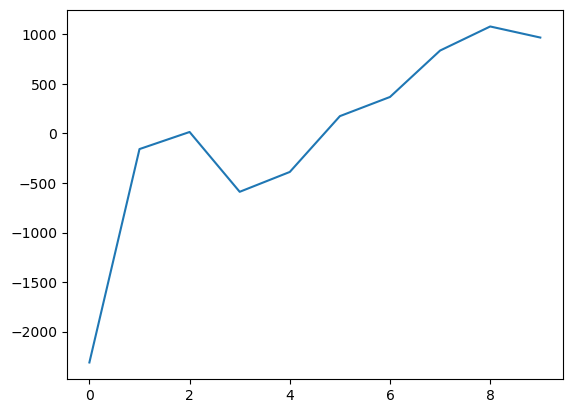

In [111]:
print(time_series2_comp[0:10])
std_dev = np.std(time_series2_comp[0:10]/np.mean(time_series2_comp[0:10]))
print(std_dev)
plt.plot((time_series2_comp[0:10]/np.mean(time_series2_comp[0:10])-1)*10**6)

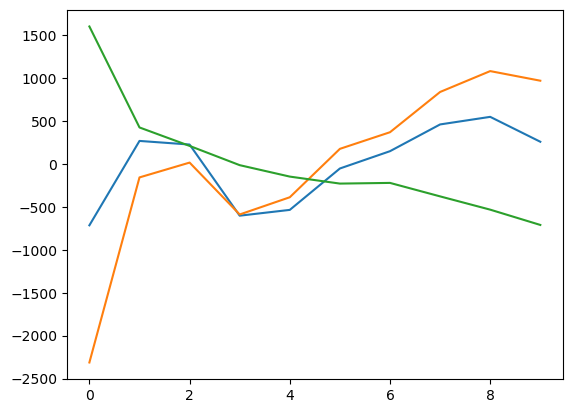

[0.51513987 0.51453507 0.51442464 0.51430928 0.51424079 0.5141989
 0.514203   0.51412226 0.5140428  0.51395123]
0.0003187424321232121


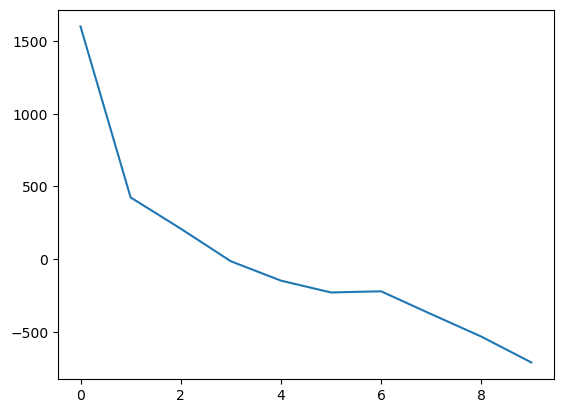

In [112]:
print(time_series2[0:10]/time_series2_comp[0:10])
divided = time_series2[0:10]/time_series2_comp[0:10]
std_dev = np.std(divided)
print(std_dev)
plt.plot((divided/np.mean(divided)-1)*10**6)

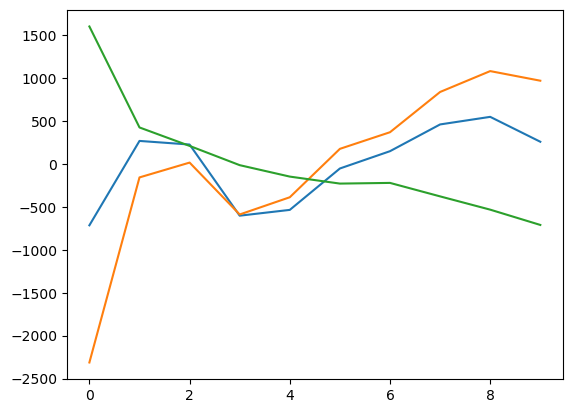

In [114]:
plt.plot(((time_series2[0:10]/np.mean(time_series2[0:10]))-1)*10**6)
plt.plot((time_series2_comp[0:10]/np.mean(time_series2_comp[0:10])-1)*10**6)
plt.plot((divided/np.mean(divided)-1)*10**6)

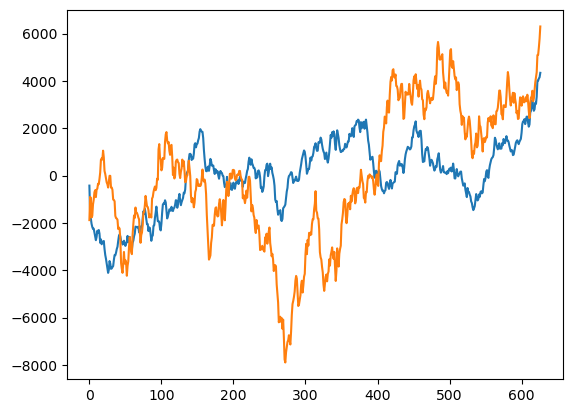

In [72]:
flux_target = ((time_series2)/np.mean(time_series2))*10**6
flux_target_0norm = ((time_series2-np.mean(time_series2))/np.mean(time_series2))*10**6
flux_comp = ((time_series2_comp)/np.mean(time_series2_comp))*10**6
#plt.plot(((time_series2)/np.mean(time_series2))*10**6)/(((time_series2_comp)/np.mean(time_series2_comp))*10**6)
plt.plot(((flux_target/flux_comp)-1)*10**6)
plt.plot(flux_target_0norm)

In [11]:
from pylab import *
import expecto
import pysynphot


def normalize_expecto_to_magnitude(expecto_wave, expecto_flux, magnitude):

    expecto_flux /= 10**8 #to ergs/s/cm^2/Ang
    h = pysynphot.units.H # ergs * s
    c = pysynphot.units.C #meters/second
    c *= 10**10 #Angstroms/second

    ergs_to_photons = h*c/expecto_wave

    expecto_flux /= ergs_to_photons

    sp = pysynphot.ArraySpectrum(expecto_wave.value, expecto_flux.value)
    sp_norm = sp.renorm(magnitude, 'vegamag', pysynphot.ObsBandpass('2mass,j'))
    

    return sp_norm.wave, sp_norm.flux

In [12]:
expecto_spectrum = get_spectrum(T_eff = 5800, log_g = 4.5, cache = False) #units are ergs/s/cm^2/cm

expecto_flux = expecto_spectrum.flux
expecto_wave = expecto_spectrum.wavelength

wave, flux = normalize_expecto_to_magnitude(expecto_wave, expecto_flux, 10)
plt.plot(wave, flux)
plt.yscale('log')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'comp/nonhst/2mass_j_001_syn.fits'